In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
# 1. Fetch Fama-French 25 Portfolios
print("Downloading Fama-French 25 Portfolios...")

ds = web.DataReader('25_Portfolios_5x5', 'famafrench', start='1960-01-01', end='2023-12-31')
returns = ds[0]

# Cleaning
returns = returns / 100.0

# Convert to PyTorch Tensors
returns_tensor = torch.tensor(returns.values, dtype=torch.float32)

In [3]:
# 2. Construct Latent Factors

N_FACTORS = 25

# Method 1: PCA Factors

pca = PCA(n_components=N_FACTORS)
pca.fit((returns - returns.mean(axis=0)) / returns.std(axis=0))
pca_loadings = pca.components_.T
F_pca = returns @ pca_loadings[:, :N_FACTORS]
F_pca = F_pca.to_numpy()

# Method 2: DAE Factors

class FinanceAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(FinanceAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.Tanh(),
            nn.Linear(50, latent_dim) # Latent factors
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 50),
            nn.Tanh(),
            nn.Linear(50, input_dim) # Linear output (returns are unbounded)
        )

    def forward(self, x):
        factors = self.encoder(x)
        reconstruction = self.decoder(factors)
        return reconstruction, factors

# Setup
torch.manual_seed(1210)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = returns.shape[1]
model = FinanceAE(input_dim, N_FACTORS).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 100
batch_size = 32
model.train()

for epoch in range(epochs):
    permutation = torch.randperm(returns_tensor.size()[0])
    for i in range(0, returns_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = returns_tensor[indices].to(device)

        # Forward
        outputs, _ = model(batch_x)
        loss = criterion(outputs, batch_x)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Extract Factors
model.eval()
with torch.no_grad():
    _, F_ae = model(returns_tensor.to(device))

    F_ae = F_ae.cpu().numpy()

In [4]:
# 3. Helper Functions

def elasticnet_objective(b, mu, Sigma, gamma1, gamma2):
    diff = mu - Sigma @ b
    hj_dist = diff.T @ np.linalg.solve(Sigma, diff)
    penalty_L2 = gamma2 * np.sum(b ** 2)
    penalty_L1 = gamma1 * np.sum(np.abs(b))
    return hj_dist + penalty_L2 + penalty_L1

def elasticnet_estimator(mu, Sigma, gamma1, gamma2):
    b = cp.Variable(len(mu))
    b.value = np.zeros(len(mu))
    obj = cp.quad_form(mu - Sigma @ b, np.linalg.inv(Sigma)) + gamma1 * cp.norm(b, 1) + gamma2 * cp.sum_squares(b)
    problem = cp.Problem(cp.Minimize(obj))
    problem.solve()
    return b.value

def cv_elasticnet_r2_oos(ret, gamma1_grid, gamma2_grid, K=3):
    T = ret.shape[0]
    fold_size = T // K
    r2_mat = np.full((len(gamma1_grid), len(gamma2_grid)), np.nan)

    for i, gamma1 in enumerate(gamma1_grid):
        for j, gamma2 in enumerate(gamma2_grid):
            r2_folds = np.zeros(K)

            for k in range(K):
                start = k * fold_size
                end = (k + 1) * fold_size if k < K - 1 else T
                idx_test = np.arange(start, end)
                idx_train = np.setdiff1d(np.arange(T), idx_test)

                ret_train = ret[idx_train, :]
                ret_test = ret[idx_test, :]

                mu_train = np.mean(ret_train, axis=0)
                Sigma_train = np.cov(ret_train, rowvar=False)

                mu_test = np.mean(ret_test, axis=0)
                Sigma_test = np.cov(ret_test, rowvar=False)

                b_hat = elasticnet_estimator(mu_train, Sigma_train, gamma1, gamma2)

                pred = Sigma_test @ b_hat
                resid = mu_test - pred
                r2 = 1 - (resid.T @ resid) / (mu_test.T @ mu_test)
                r2_folds[k] = r2

            r2_mat[i, j] = np.mean(r2_folds)

    best_idx = np.unravel_index(np.argmax(r2_mat), r2_mat.shape)
    return {
        "best_gamma1": gamma1_grid[best_idx[0]],
        "best_gamma2": gamma2_grid[best_idx[1]],
        "best_r2": r2_mat[best_idx],
        "r2_matrix": r2_mat,
        "best_index": best_idx,
    }

In [5]:
# 4. Construct SDF and evaluate OOS R^2

gamma1_grid = np.logspace(-4.5, -1.5, 10)
gamma2_grid = np.logspace(-2.5, 1.5, 20)

# Method 1: PCA Factors

cv_results_elastic_pca = cv_elasticnet_r2_oos(F_pca, gamma1_grid, gamma2_grid, K=3)
print("Using PCA Factors:")
print("Best gamma1:", cv_results_elastic_pca["best_gamma1"])
print("Best gamma2:", cv_results_elastic_pca["best_gamma2"])
print("Best R2_oos:", round(cv_results_elastic_pca["best_r2"], 4))

# Method 2: Autoencoder Factors

cv_results_elastic_ae = cv_elasticnet_r2_oos(F_ae, gamma1_grid, gamma2_grid, K=3)
print("\nUsing Autoencoder Factors:")
print("Best gamma1:", cv_results_elastic_ae["best_gamma1"])
print("Best gamma2:", cv_results_elastic_ae["best_gamma2"])
print("Best R2_oos:", round(cv_results_elastic_ae["best_r2"], 4))

Using PCA Factors:
Best gamma1: 0.01467799267622069
Best gamma2: 0.005134832907437549
Best R2_oos: 0.864

Using Autoencoder Factors:
Best gamma1: 0.03162277660168379
Best gamma2: 0.005134832907437549
Best R2_oos: 0.1879


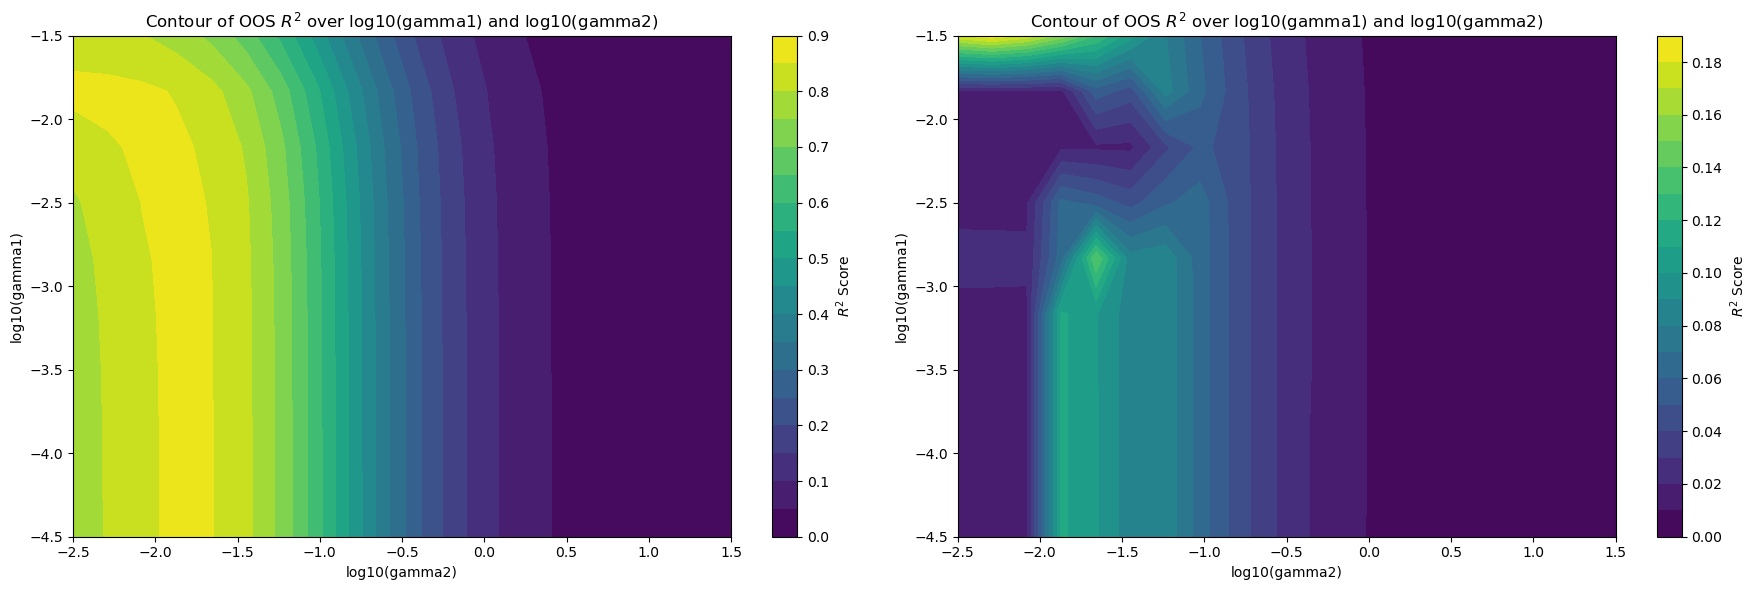

In [6]:
# 5. Plotting

G2, G1 = np.meshgrid(np.log10(gamma2_grid), np.log10(gamma1_grid))

# Plot the contour
# plt.figure(figsize=(8, 6))
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
contour_pca = axes[0].contourf(G2, G1, cv_results_elastic_pca['r2_matrix'], levels=20, cmap='viridis')  # Filled contour
plt.colorbar(contour_pca, label=r'$R^2$ Score')
axes[0].set_xlabel('log10(gamma2)')
axes[0].set_ylabel('log10(gamma1)')
axes[0].set_title(r'Contour of OOS $R^2$ over log10(gamma1) and log10(gamma2)')

contour_ae = axes[1].contourf(G2, G1, cv_results_elastic_ae['r2_matrix'], levels=20, cmap='viridis')  # Filled contour
plt.colorbar(contour_ae, label=r'$R^2$ Score')
axes[1].set_xlabel('log10(gamma2)')
axes[1].set_ylabel('log10(gamma1)')
axes[1].set_title(r'Contour of OOS $R^2$ over log10(gamma1) and log10(gamma2)')

plt.tight_layout()
plt.savefig('./figs/exp_2_contours.pdf', dpi=300)
plt.show()

In [7]:
mu_pca = np.mean(F_pca, axis=0)
Sigma_pca = np.cov(F_pca, rowvar=False)
b_enet_pca = elasticnet_estimator(mu_pca, Sigma_pca, gamma1=cv_results_elastic_pca["best_gamma1"], gamma2=cv_results_elastic_pca["best_gamma2"])
print("Number of non-zero coefficients (PCA):", np.sum(np.abs(b_enet_pca) > 1e-8))

mu_ae = np.mean(F_ae, axis=0)
Sigma_ae = np.cov(F_ae, rowvar=False)
b_enet_ae = elasticnet_estimator(mu_ae, Sigma_ae, gamma1=cv_results_elastic_ae["best_gamma1"], gamma2=cv_results_elastic_ae["best_gamma2"])
print("Number of non-zero coefficients (Autoencoder):", np.sum(np.abs(b_enet_ae) > 1e-8))

Number of non-zero coefficients (PCA): 1
Number of non-zero coefficients (Autoencoder): 21
